In [343]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
import nasdaqdatalink
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [345]:
%matplotlib inline

In [347]:
nasdaqdatalink.ApiConfig.api_key = 'G4rBGsL1Ahu2eXFzsGym'

In [349]:
# Retrieve data from the Zillow dataset
data = nasdaqdatalink.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id='207')

# Display the first few rows of the dataset
print(data.head())

     indicator_id region_id       date          value
None                                                 
0            ZSFH       207 2024-07-31  940716.775201
1            ZSFH       207 2024-06-30  939047.390798
2            ZSFH       207 2024-05-31  935259.614578
3            ZSFH       207 2024-04-30  927286.480460
4            ZSFH       207 2024-03-31  918186.643089


ZSFH stands fro Single-Family Homes and the data represent King County, WA between 1996 to 2024.

In [352]:
data.shape

(343, 4)

In [357]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,207,2024-07-31,940716.775201
1,ZSFH,207,2024-06-30,939047.390798
2,ZSFH,207,2024-05-31,935259.614578
3,ZSFH,207,2024-04-30,927286.480460
4,ZSFH,207,2024-03-31,918186.643089


In [359]:
data.tail()

,indicator_id,region_id,date,value
None,,,,
338,ZSFH,207,1996-05-31,194005.0
339,ZSFH,207,1996-04-30,193992.0
340,ZSFH,207,1996-03-31,193947.0
341,ZSFH,207,1996-02-29,193923.0
342,ZSFH,207,1996-01-31,193819.0


### Data Wrangling and Cleaning 

In [367]:
# checking summary of statistics of our data
data.describe()

,date,value
count,343,343.000000
mean,2010-04-30 22:15:02.623906816,465651.027810
min,1996-01-31 00:00:00,193819.000000
25%,2003-03-15 12:00:00,312599.157685
50%,2010-04-30 00:00:00,404744.388435
75%,2017-06-15 00:00:00,586979.553204
max,2024-07-31 00:00:00,992623.204754
std,NaN,207760.687076


In [369]:
# checking for missing values
data.isnull().sum()

indicator_id    0
region_id       0
date            0
value           0
dtype: int64

In [365]:
# checking data types
data.dtypes

indicator_id            object
region_id               object
date            datetime64[ns]
value                  float64
dtype: object

In [371]:
# assigning date as the index of our dataset
from datetime import datetime
data['datetime'] = pd.to_datetime(data['date'])
data = data.set_index('datetime')
data.drop(['date'], axis=1, inplace=True)

In [373]:
data.head()

,indicator_id,region_id,value
datetime,,,
2024-07-31,ZSFH,207,940716.775201
2024-06-30,ZSFH,207,939047.390798
2024-05-31,ZSFH,207,935259.614578
2024-04-30,ZSFH,207,927286.480460
2024-03-31,ZSFH,207,918186.643089


In [375]:
# dropping indicator_id and region_id columns 
data.drop(columns=['indicator_id', 'region_id'], inplace=True)

In [379]:
data.head()

,value
datetime,
2024-07-31,940716.775201
2024-06-30,939047.390798
2024-05-31,935259.614578
2024-04-30,927286.480460
2024-03-31,918186.643089


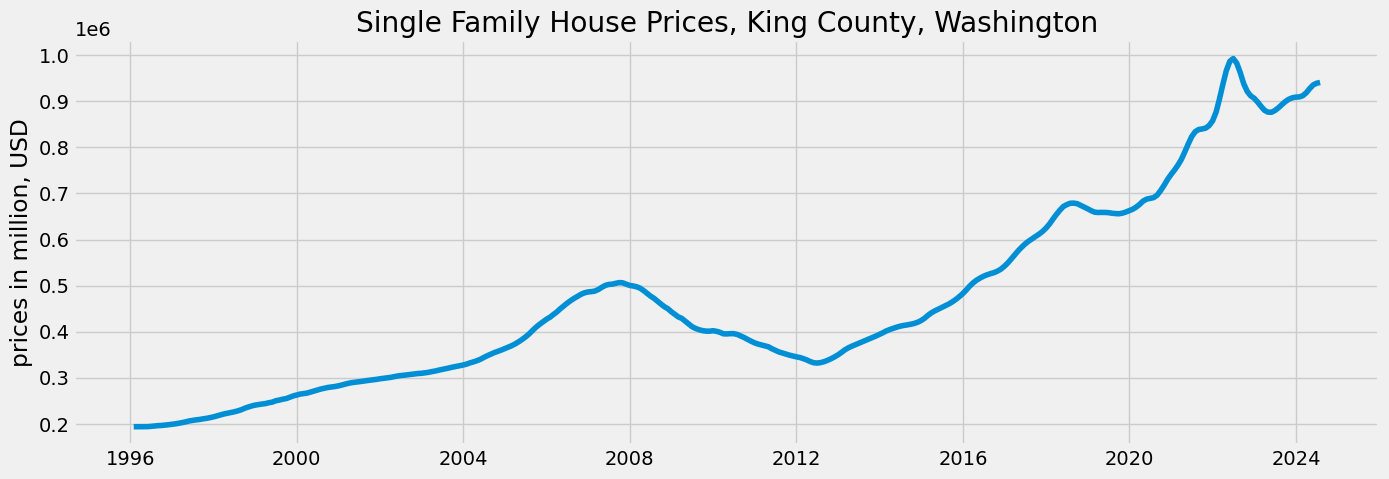

In [387]:
# Plot the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100) 
plt.title('Single Family House Prices, King County, Washington')
plt.ylabel('prices in million, USD')
plt.plot(data)
plt.show()

In [389]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [391]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

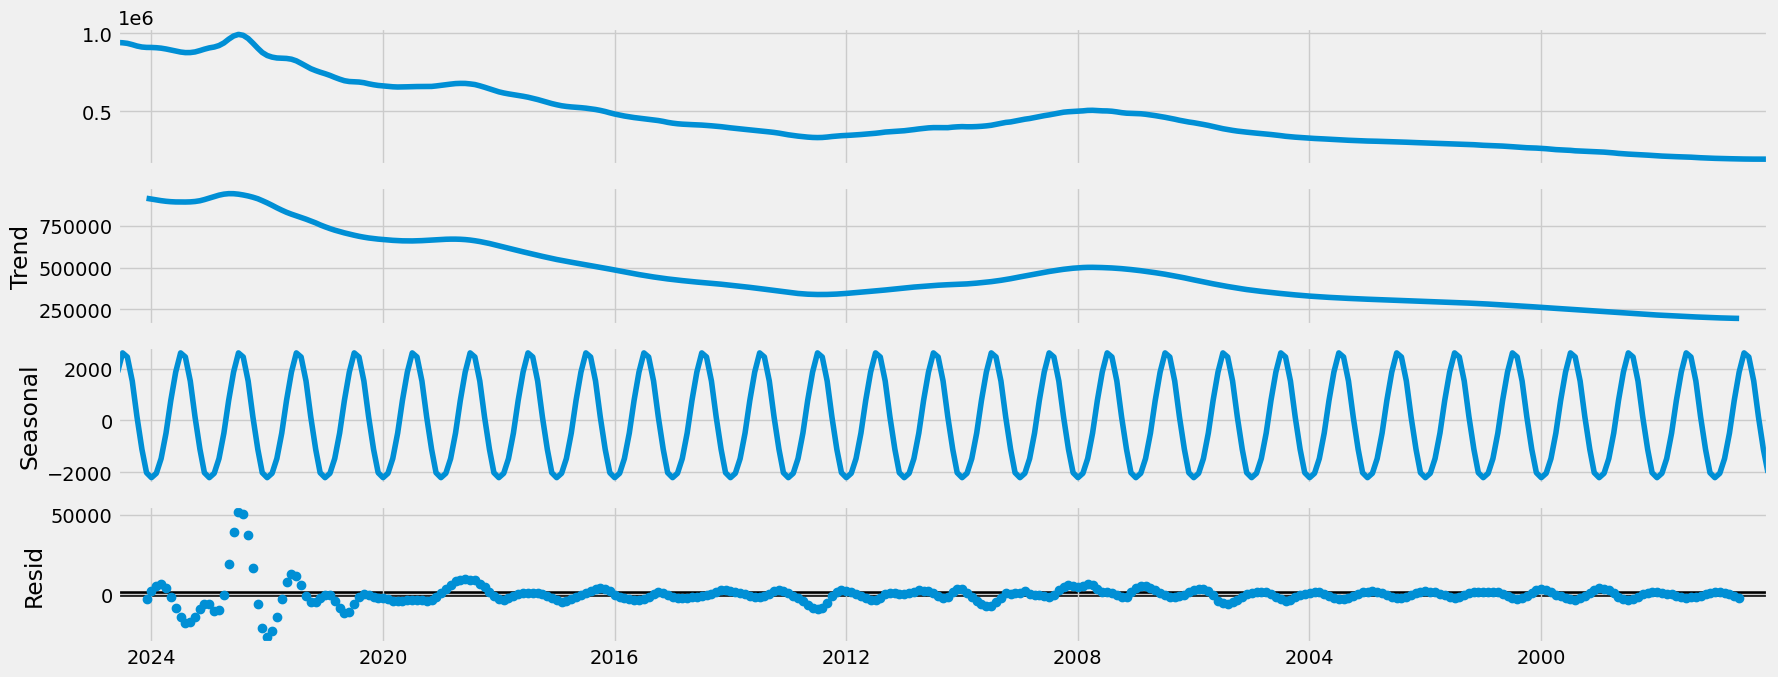

In [393]:
decomposition.plot()
plt.show()

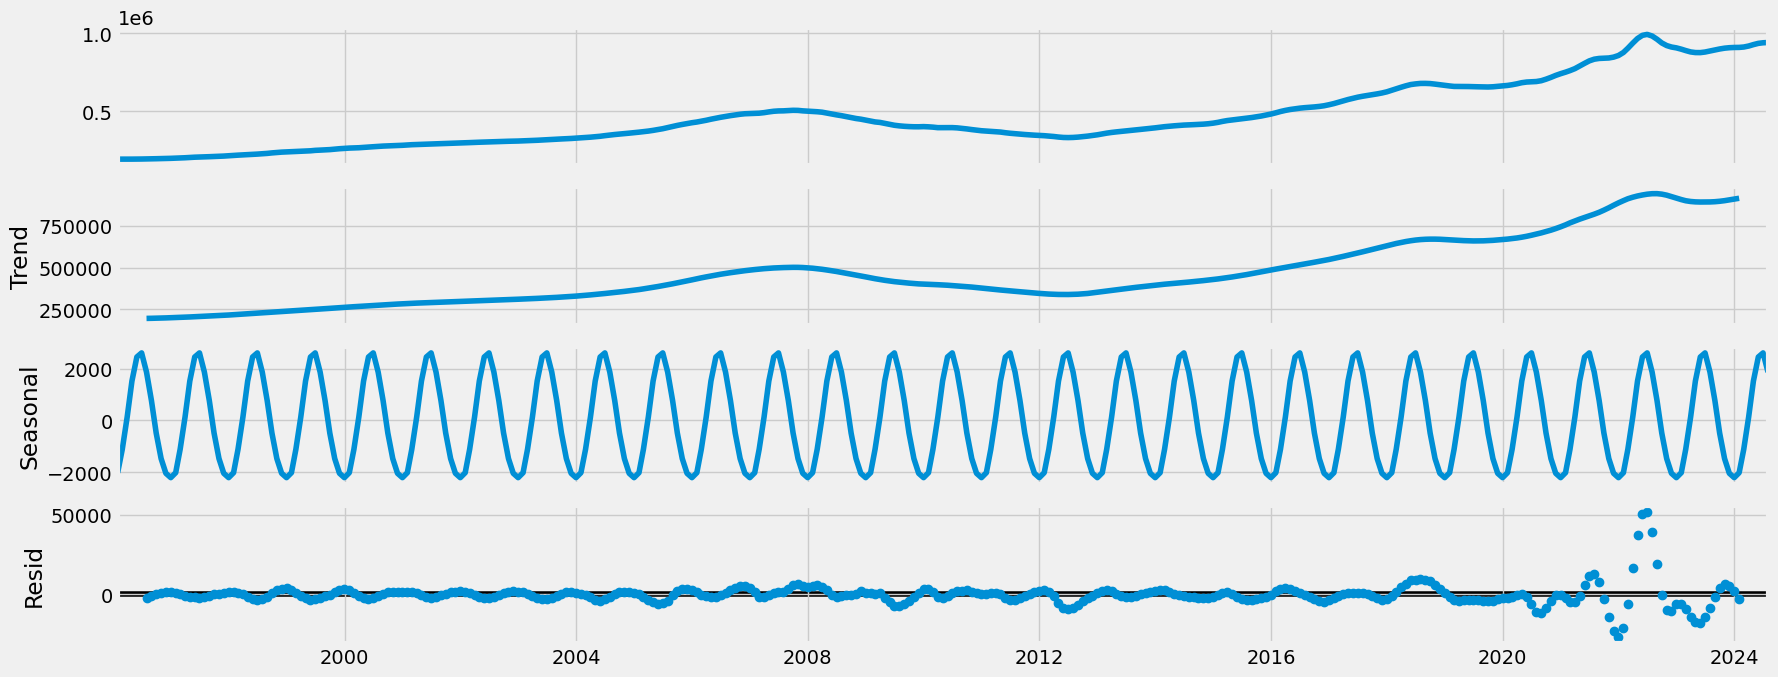

In [401]:
# Plot the decomposition results
decomposition.plot()
# Invert the x-axis so the chart goes from 1996 to 2024
plt.gca().invert_xaxis()
# Show the plot
plt.show()

### Testing Stationarity

In [405]:
data.head()

,value
datetime,
2024-07-31,940716.775201
2024-06-30,939047.390798
2024-05-31,935259.614578
2024-04-30,927286.480460
2024-03-31,918186.643089


In [399]:
data.shape

(343, 1)

In [411]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.811943
p-value                          0.056588
Number of Lags Used             17.000000
Number of Observations Used    325.000000
Critical Value (1%)             -3.450632
Critical Value (5%)             -2.870474
Critical Value (10%)            -2.571530
dtype: float64


The p-value indicates the probability of observing the data if the null hypothesis (that the time series has a unit root and is non-stationary) is true. A lower p-value suggests that we can reject the null hypothesis. A common threshold for significance is 0.05 (5%). Since our p-value (0.056588) is slightly above this threshold, we do not have enough evidence to reject the null hypothesis at the 5% significance level. Based on the value of p, we can conclude that our data is non-stationary. Additionally, at 1% level the test statistic (-2.811943) is greater than the critical value (-3.450632). Therefore, we cannot reject the null hypothesis of non-stationarity. At the 5% level the test statistic (-2.811943) is again greater than the critical value (-2.870474). Therefore, we cannot reject the null hypothesis of non-stationarity. And finally tt 10% level, the test statistic (-2.811943) is less than the critical value (-2.571530). Only at this level we can reject the null hypothesis of non-stationarity.
Although the Dicky_Fuller test shows that our data is non_stationary, however we can safely say that it is marginally close to the threshold. Instead of making a frim decision, the best way forward would be to conduct additional analysis. 

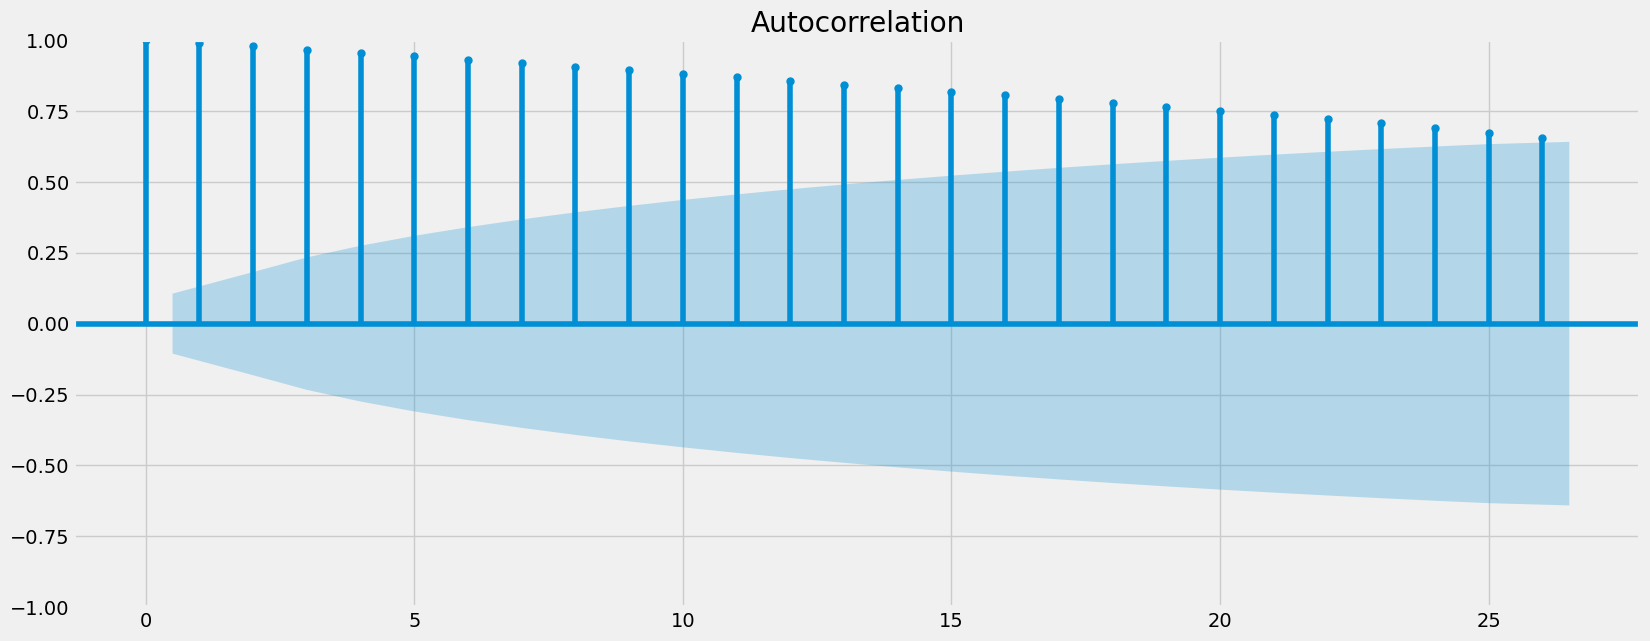

In [414]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, we import the autocorrelation and partial correlation plots
plot_acf(data)
plt.show()

All the lags, the vertical lines, go beyond the edge of the confidence interval (the blue area) and it shows that all the lags are significanlty correlated with each other, so we can conclude that our data is non-stationary. 

### Stationarizing the data

In [417]:
data_diff = data - data.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [421]:
data_diff.isnull().sum()

value    1
dtype: int64

In [423]:
data_diff.dropna(inplace = True) # Here, we remove the missing values that came about as a result of the differencing. 
# we need to remove these or we won't be able to run the Dickey-Fuller test.

In [425]:
data_diff.head()

,value
datetime,
2024-06-30,-1669.384403
2024-05-31,-3787.776220
2024-04-30,-7973.134118
2024-03-31,-9099.837370
2024-02-29,-6367.254345


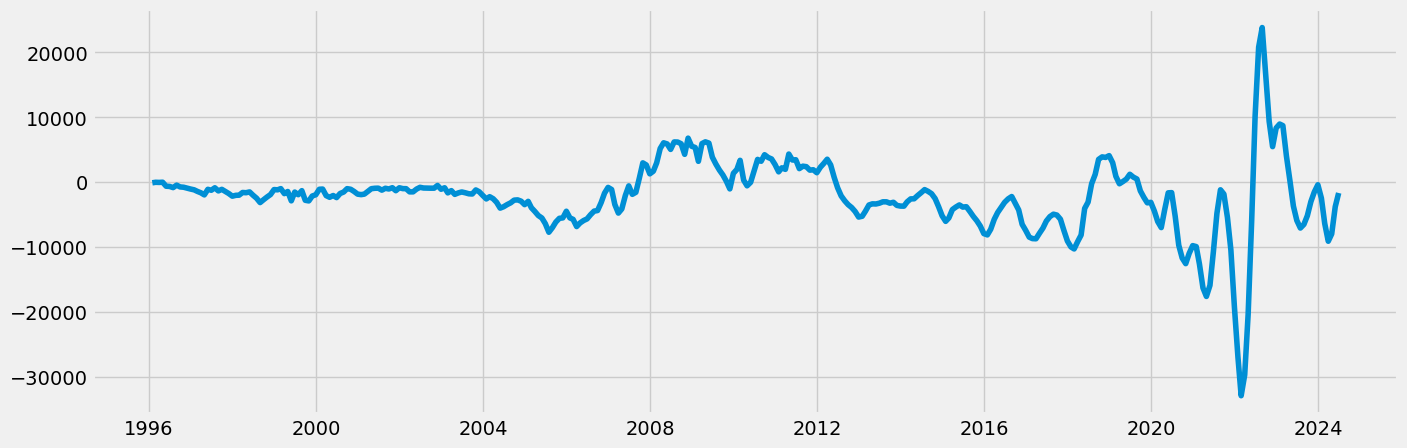

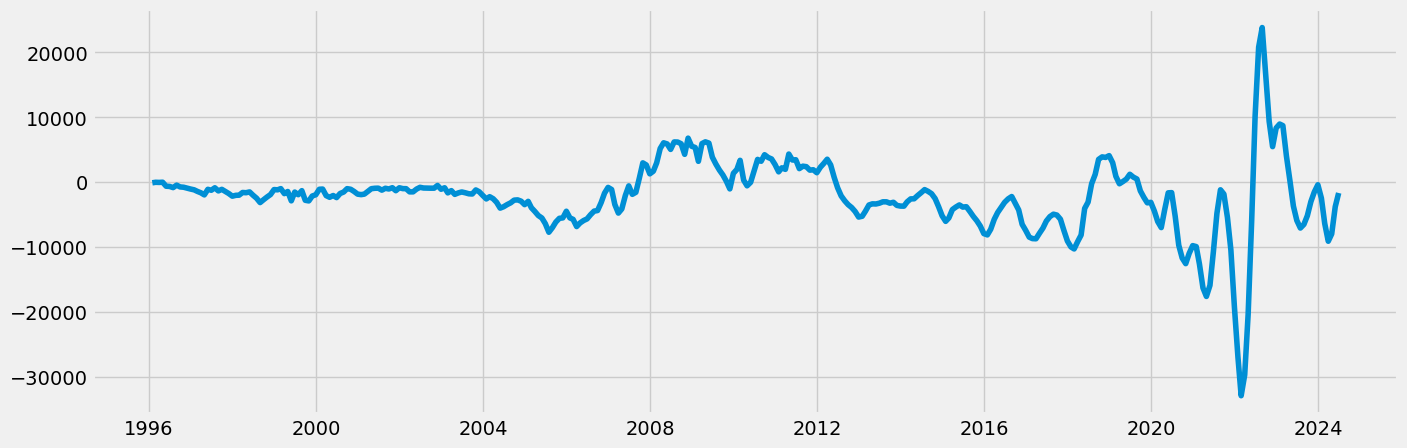

In [433]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)
plt.show()

In [435]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.207913
p-value                          0.000639
Number of Lags Used             16.000000
Number of Observations Used    325.000000
Critical Value (1%)             -3.450632
Critical Value (5%)             -2.870474
Critical Value (10%)            -2.571530
dtype: float64


The results indicate that the test statistic is -4.207913, which is significantly lower than the critical values at all levels (1%, 5%, and 10%). The p-value of 0.000639 further supports this finding, as it is well below the commonly used significance levels of 0.05. This suggests strong evidence against the null hypothesis, indicating that the time series is stationary. 

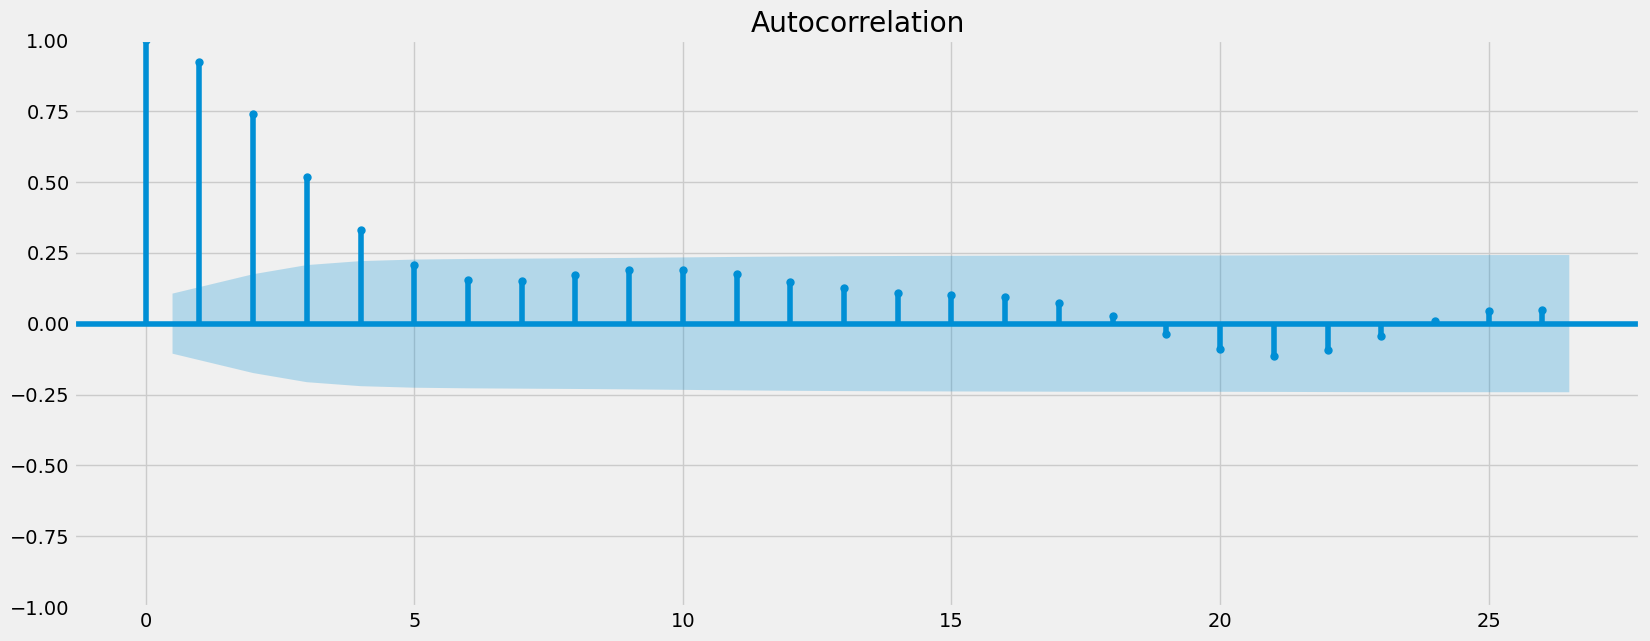

In [437]:
plot_acf(data_diff)
plt.show()

This time majority of the lags are inside the confidence interval confirming that our time series is stationary. 